In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random as rd

In [2]:
rd.seed(1)

These are the same funcitons used in the Lasso regression workbook

In [3]:
def calculate_transaction_costs(change_in_positions, cost_per_trade):
    return np.sum(np.abs(change_in_positions)) * cost_per_trade
def ret2price(ret):
    price = np.ones(len(ret))
    for i in range(1, len(ret)):
        price[i] = ret[i]*price[i-1]
    return price
def price2ret(price):
    ret = np.ones(len(price))
    for i in range(1, len(ret)):
        ret[i] = price[i]/price[i-1]
    return ret

Here we import the futures dataset as well as eliminate some of the futures from our portfolio. We removed them during the data exploration phase by considering their correlation and other financial factors in order to get a better tracking. This part was handled automatically by the Lasso penalty in the linear regression

In [4]:
# Read data
data = pd.read_excel('InvestmentReplica2.xlsx', sheet_name='Replica')
dates = data['Date'].values
data.drop(columns=['Date'], inplace=True)

# Target index
data['Target'] = 0.25 * data['HFRXGL'] + 0.5 * data['MXWO'] + 0.25 * data['LEGATRUU']

# Compute returns for all columns
returns = data.pct_change()+1
returns.drop(index=0, inplace=True)

# Features selection
features = returns.columns.drop(['HFRXGL', 'MXWO', 'LEGATRUU', 'MXWD','LLL1','Target','TP1','TY1','VG1','DU1', 'NQ1'])
target = 'Target'
X = returns[features].values
y = returns[target].values

Here's the code that implements the Kalman filter in order to predict the portfolio weights to accuratly replicate the index. Here like in the Lasso regression case we compute the amount of losses that we experienced due to transaction fees.
Also we consider the mean prediction error over the whole period

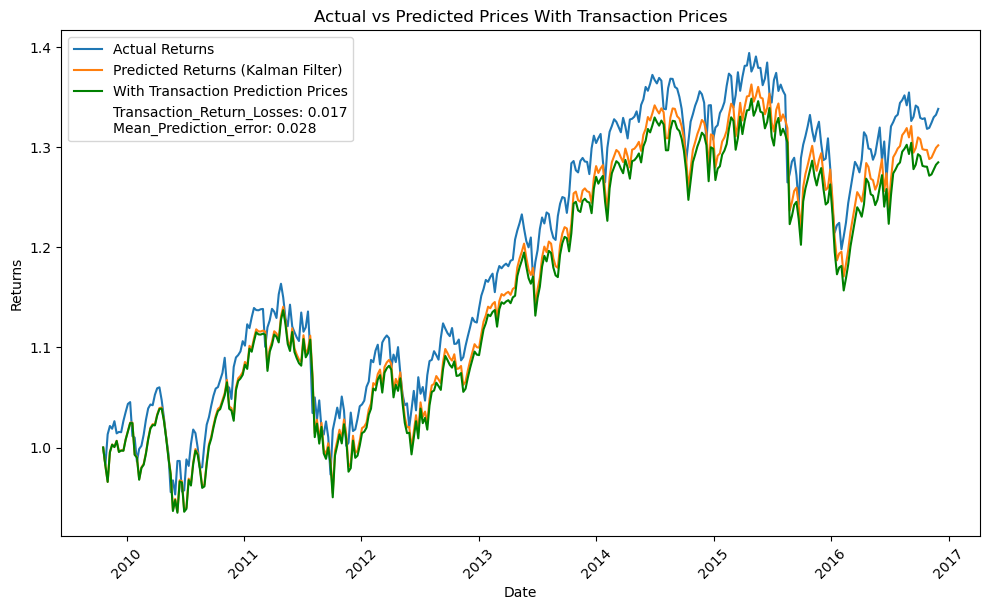

In [5]:
# Initialized vectors
y_test_kalman = []
y_pred_kalman = []
dates_plot_kalman = []

# Define parameters for Kalman filter
num_features = X.shape[1]
num_time_steps = len(y)

A = np.eye(num_features)
B = np.diag(np.diag(np.cov(X.T)))
C = np.eye(num_features)  # Initialization of C(t)
D = np.std(y)

Q = np.cov(X, rowvar=False)
R = D**2

window_size = 104

portfolio_weights=[]
adjusted_portfolio_prices=[]

# Apply rolling window with Kalman filter
for i in range(window_size, len(returns) - 1):
    # Split the data into training and testing sets using rolling window
    X_train = X[i-window_size:i]
    y_train = y[i-window_size:i]
    X_test = X[i:i+1]  # Test set contains one sample from the next time step
    
    # Initialize state estimate and covariance for the window
    x_estimate = np.zeros(num_features)
    P_estimate = np.eye(num_features)
    
    # Kalman filter loop for training set
    for t in range(window_size):
        # Predict
        x_estimate = np.dot(A, x_estimate) + np.dot(B, np.random.randn(num_features))
        P_estimate = np.dot(np.dot(A, P_estimate), A.T) + Q

        # Update
        C = X_train[t].reshape(1, -1)
        K = np.dot(np.dot(P_estimate, C.T), np.linalg.inv(np.dot(np.dot(C, P_estimate), C.T) + R))
        residual = y_train[t] - np.dot(C, x_estimate)
        x_estimate = x_estimate + np.dot(K, residual)
        P_estimate = np.dot((np.eye(num_features) - np.dot(K, C)), P_estimate)
    
    # Prediction step for the test instance
    C = X_test
    x_estimate = np.dot(A, x_estimate) + np.dot(B, np.random.randn(num_features))
    P_estimate = np.dot(np.dot(A, P_estimate), A.T) + Q
    K = np.dot(np.dot(P_estimate, C.T), np.linalg.inv(np.dot(np.dot(C, P_estimate), C.T) + R))
    residual = y_train[-1] - np.dot(C, x_estimate)
    x_estimate = x_estimate + np.dot(K, residual)
    P_estimate = np.dot((np.eye(num_features) - np.dot(K, C)), P_estimate)
    
    portfolio_weights.append(x_estimate)
    y_test_kalman.append(y[i])
    y_pred_kalman.append(np.dot(C, x_estimate))  # Only extract the prediction for the single test instance
    dates_plot_kalman.append(dates[i])

x_estimate_new={}
y_pred_kalman_new = {}
alpha = 1
         
adjusted_portfolio_prices=[1]
cost_per_unit = 0.0005  # Fee cost as percentage of the trade value

weight_changes = abs(np.diff(portfolio_weights, axis=0))
for i in range(len(weight_changes)):
    transaction_cost = calculate_transaction_costs(weight_changes[i], cost_per_unit)
    # Adjust the portfolio price by subtracting the transaction costs
    adjusted_price = adjusted_portfolio_prices[-1] * (y_pred_kalman[i+1]) - transaction_cost
    adjusted_portfolio_prices.append(adjusted_price[0])

prices_test_kalman = ret2price(np.array(y_test_kalman))
prices_pred_kalman = ret2price(np.array(y_pred_kalman))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(dates_plot_kalman, prices_test_kalman, label='Actual Returns')
plt.plot(dates_plot_kalman, prices_pred_kalman, label='Predicted Returns (Kalman Filter)')
plt.plot(dates_plot_kalman , adjusted_portfolio_prices, label='With Transaction Prediction Prices', color='Green')

Transaction_losses=prices_pred_kalman[-1]-adjusted_portfolio_prices[-1]

Mean_Prediction_error=np.mean(np.abs(prices_pred_kalman-prices_test_kalman))

extra_legend_labels = [
    f'Transaction_Return_Losses: {Transaction_losses:.3f}\n'
    f'Mean_Prediction_error: {Mean_Prediction_error:.3f}'
    ]

# Add dummy plots for the extra legend entries
plt.plot([], [], ' ', label=extra_legend_labels[0])

plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('Actual vs Predicted Prices With Transaction Prices')
plt.show()

We notice that the Kalman filter has a better tracking than the Lasso regression with monthly rebalancing for the considered time period (Mean Prediction error = 0.031 vs 0.035) even if the lasso was optimized on the set.

While it compleatly outperforms the lasso regression on a weekly basis.

Reguarding transaction costs we get analogous results to the lasso regression.